# Assignment 10: Regression with discrete variables
## Learning Outcomes:
This assignment introduces the use of discrete variables in regression analysis. Task 1 will use discrete variables as explanatory variables, in Task 2 we will use discrete variables as response variables and introduce logistic regression. 

## Data set 
Throught the assignment you will use the full possum.csv data set.  
The data set includes measures from 104 possums that were caught in New Zealand in a field study. 
Variables: 
-	site: The site number where the possum was trapped.
-	pop: Population, either Vic (Victoria) or other (New South Wales or Queensland).
-	sex: Gender, either m (male) or f (female).
-	age: Age in years
-	headL: Head length, in mm.
-	skullW: Skull width, in mm.
-	totalL: Total length, in cm.
-	tailL: Tail length, in cm.

## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib, scipy.optimize. This is already done in the preliminaries. Ensure that you have fully mastered all previous assignments (especially 8, 9) before starting the assignment. Import the regression functions that you used for the last homeworks. 

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.optimize as so
import pandas as pd 
import numpy as np

def simpleRegPredict(b,x):
    yp=b[0]+b[1]*x
    return yp 

def simpleRegLossRSS(b,x,y):
    predY = simpleRegPredict(b,x)
    res = y-predY
    rss = sum(res**2)
    deriv = np.zeros(2)
    deriv[0]=-2*sum(res)
    deriv[1]=-2*sum(res*x)
    return (rss,deriv)

def simpleRegLossSAD(b,x,y):
    predY = simpleRegPredict(b,x)
    res = y-predY
    sad = sum(res.abs())
    deriv = np.zeros(2)
    deriv[0]=-sum(np.sign(res))
    deriv[1]=-sum(np.sign(res)*x)
    return (sad,deriv)

def plotPrediction(b,x,y,predfcn):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x,y)
    xp = np.linspace(min(x),max(x),num=50)
    yp = predfcn(b,xp)
    ax.plot(xp,yp,'r')
    
def simpleRegFit(x,y,lossFcn=simpleRegLossRSS):
    b0=[np.mean(y),0]
    RES = so.minimize(lossFcn,b0,args=(x,y),jac=True)
    b=RES.x # Results
    plotPrediction(b,x,y,simpleRegPredict)
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,grad = simpleRegLossRSS(b,x,y)
    R2 = 1-RSS/TSS 
    return (R2,b)

def addPrediction(b,x,predFunc,ax,linestyle='r:'):
    xrange = max(x)-min(x)
    xp = np.linspace(min(x)-xrange/30,max(x)+xrange/30,num=50)
    yp = predFunc(b,xp)
    ax.plot(xp,yp,linestyle)
    return(ax)
    


def multRegPredict(b,D,xname):
    yp=np.ones(len(D.index))*b[0]        # Intercept 
    for i in range(len(xname)):          
        yp=yp+D[xname[i]]*b[i+1]         # Add each regression value 
    return yp 

def multRegLossRSS(b,D,y,xname):
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)
    return (rss,grad)

def multRegFit(D,y,xname):
    N=len(xname)
    b0=np.zeros((N+1,1))
    RES = so.minimize(multRegLossRSS,b0,args=(D,y,xname),jac=True)
    if (not(RES.success)):
        print('unsuccessful fit')
        print(RES)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS 
    return (R2,b)

def leaveOneOutCV(x,y,fitfcn=multRegFit,args=(),predictfcn=multRegPredict):
    N = len(x) #Number of observations 
    yp= np.zeros(N)
    ind = np.arange(N)
    for i in range(N):
        r,b,ax=fitfcn(x[ind!=i],y[ind!=i],args,fig=False)
        yp[i]=predictfcn(b,x[i])
    TSS  = sum((y-y.mean())**2)
    RSScv = sum((y-yp)**2)
    R2cv = 1-RSScv/TSS

    # Get the model fit 
    r,b,ax=fitfcn(x,y,args)
    yf=predictfcn(b,x)
    RSS   = sum((y-yf)**2)
    R2 = 1-RSS/TSS
    return R2cv,R2 


def bootstrapReg(D,y,args,fitfcn,numIter=1000):
    r2,b=fitfcn(D,y,args)
    numParams=len(b)
    N = len(D.index)
    ind  = np.arange(N)
    stats = np.zeros((numIter,numParams))
    for i in range(numIter):
        sample=np.random.choice(ind,N)
        r2,stats[i,:]=fitfcn(D.iloc[sample],y[sample],args)
    return stats

def confidenceInt(data,perc):
    Int=(np.percentile(data,(100-perc)/2),np.percentile(data,100-(100-perc)/2))
    return Int


## Task 1: Discrete predictor variables

### Question 1 (5 pt)
Load the data set possum.csv. 
Generate 3 new columns in the data frame: 
- bodyL: The length of the main body (totalL - tailL) 
- popI:  Population identifier, 0: if pop is 'other', 1: if pop is 'Vic'
- sexI:  Sex indentifier, 0: if sex is 'm', 1: if sex is 'f'
Use your function multRegression to run a regression analysis of bodyL (response variable) against sexI (explanatory variable). Make a plot (with labeled axes) that show sex on the x-axis and body length on the y axis. Add the prediction line from the regression. 

Text(0, 0.5, 'Body length [cm]')

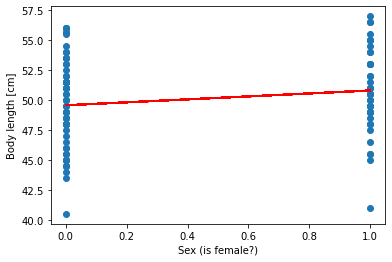

In [2]:
D=pd.read_csv('possum.csv')
D['bodyL']=D['totalL']-D['tailL']
D['popI']=np.double(D['pop']=='Vic')
D['sexI']=np.double(D['sex']=='f')
R2,b=multRegFit(D,D.bodyL,['sexI'])
plt.scatter(D.sexI,D.bodyL)
yp = multRegPredict(b,D,['sexI'])
plt.plot(D.sexI,yp,'r-')
plt.xlabel('Sex (is female?)')
plt.ylabel('Body length [cm]')

# D

*Figure*. scatter plot of body length in two sex groups (female = 1 and male = 0). The linear regression line with the sex as the regressor is plotted in red on top of the scatter plot.

### Question 2 (10pt)
Use boostrap to estimate a 95% confidence interval on the regression parameter of sex as a explanatory variable for body length. Report the interval. Can you reject the null-hypothesis that body length in possums does not differ between the sexes?  

Confidence interval for influence of sex -0.15-2.63


Text(0, 0.5, 'frequency')

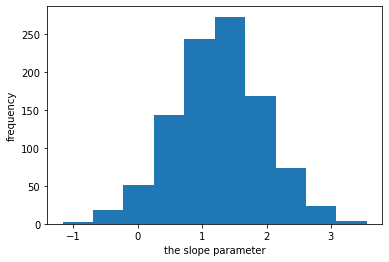

In [3]:
B=bootstrapReg(D,D.bodyL,['sexI'],multRegFit)
plt.hist(B[:,1])
Int1=confidenceInt(B[:,1],95)
print("Confidence interval for influence of sex {0:3.2f}-{1:3.2f}".format(Int1[0],Int1[1]))
plt.xlabel('the slope parameter')
plt.ylabel('frequency')

*Figure*. The histogram for the slope parameter.

> The confidence interval includes 0, so we cannot reject the null-hypothesis that body length (male) != body length (female)

### Question 3 (10pt)
Make a scatter plot of age (x-axis) against body length (y-axis), with male and female possums shown in different colors. 
You can do this by plotting two scatter plots sequentially - each time selecting either male or female possums. The second one will simply add points in a different color to the first plot.  

Estimate a multiple regression model that explains bodyL as a function of age and sex. What is the R2-value? 

Get the predicted values from the regression, and plot the predicted values in the same graph seperately for male and female possums. 

R2 is 0.09


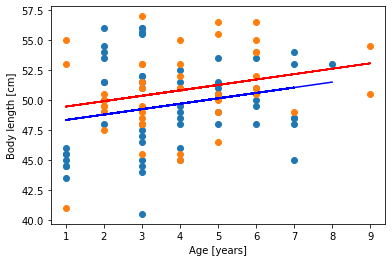

In [4]:
plt.scatter(D.age[D.sexI==0],D.bodyL[D.sexI==0])
plt.scatter(D.age[D.sexI==1],D.bodyL[D.sexI==1])
R2,b=multRegFit(D,D.bodyL,['age','sexI'])
yp = multRegPredict(b,D,['age','sexI'])
plt.plot(D.age[D.sexI==0],yp[D.sexI==0],'b-')
plt.plot(D.age[D.sexI==1],yp[D.sexI==1],'r-')
plt.xlabel('Age [years]')
plt.ylabel('Body length [cm]')
print("R2 is {0:3.2f}".format(R2))

*Figure*. scatter plot of body length vs age. Data points are grouped by sex (male and female)

> Blue dots are showing male, the orange dots are showing the female possums. The R2 of the combined model is 0.09. 

### Question 4 (7pt)
Run a bootstrap analysis on the bodyL ~ age + sexI regression model. Report the 95% confidence interval for the regression parameters of sex and age on body length. Is the effect of age onto body length significant in the context of the model? How about the relationship between sex and body length?  


In [5]:
B=bootstrapReg(D,D.bodyL,['age','sexI'],multRegFit)
Int1=confidenceInt(B[:,1],95)
Int2=confidenceInt(B[:,2],95)
print("Confidence interval for influence of age {0:3.2f}-{1:3.2f}".format(Int1[0],Int1[1]))
print("Confidence interval for influence of sex {0:3.2f}-{1:3.2f}".format(Int2[0],Int2[1]))

Confidence interval for influence of age 0.11-0.80
Confidence interval for influence of sex -0.19-2.41


> The influence of age onto bodyLength is significant - the influence of sex is not. 

### Question 5 (10pt)
Estimate a multiple regression model that explains bodyL as a function of age and population (Vic vs. other). What is the R2-value? Make a scatter plot like for Question 3, but this time splitting the data for the two populations, rather than based on sex. Which of the two population (Vic or other) is larger? How do you interpret the value of the regression coefficient for popI? 

R2 is 0.18
The regression value is 2.48


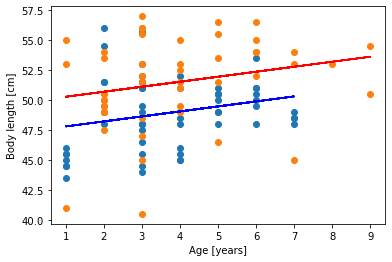

In [6]:
R2,b=multRegFit(D,D.bodyL,['age','popI'])
yp = multRegPredict(b,D,['age','popI'])
plt.scatter(D.age[D.popI==0],D.bodyL[D.popI==0])
plt.scatter(D.age[D.popI==1],D.bodyL[D.popI==1])
plt.plot(D.age[D.popI==0],yp[D.popI==0],'b-')
plt.plot(D.age[D.popI==1],yp[D.popI==1],'r-')
plt.xlabel('Age [years]')
plt.ylabel('Body length [cm]')
print("R2 is {0:3.2f}".format(R2))
print("The regression value is {0:3.2f}".format(b[2]))

*Figure*. Scatter plot of body lengths vs Age. The data points are grouped by population groups (Victorian and other)

In [7]:
len(D.age[D.popI==1])

46

In [8]:
len(D.age[D.popI==0])

58

> The number of data points in the "other" population group is higher.

> The regression parameter for popI is the difference between the means of the two groups.

### Question 6 (8pt)
Run a bootstrap analysis on the bodyL ~ age + popI regression model. Report the 95% confidence interval for the regression parameters of popI and age on body length. Is the effect of age onto body length significant in the context of the model? How about the relationship between population and body length? 


In [9]:
B=bootstrapReg(D,D.bodyL,['age','popI'],multRegFit)
Int1=confidenceInt(B[:,1],95)
Int2=confidenceInt(B[:,2],95)
print("Confidence interval for influence of age {0:3.2f}-{1:3.2f}".format(Int1[0],Int1[1]))
print("Confidence interval for influence of population {0:3.2f}-{1:3.2f}".format(Int2[0],Int2[1]))

Confidence interval for influence of age 0.10-0.76
Confidence interval for influence of population 1.12-3.71


> Both confidence intervals exclude 0, so it can be said that the the effects of both age and population on body length are significant.

## Task 2: Discrete response variable
In this task we will investigate regression models in which the response variable is a discrete, dichotomous variable. 
### Question 1: Logistic Function (10pt)
Starting with your function for multRegPredict, write a function logisticRegPredict(b,D,xname). As inputs it should take the 
- b: np-array of regression coefficients (the first one being the intercept)
- D: Data frame
- xname: a list of column names (in D) that are being used as regressors. 

The function should first calculate a = b[0] + b[1] * D[xname[0]] + b[2] * D[xname[1]] 
and then return the logistic function of a. 

Then make a Data frame with a single column with the values from -4 to 4 (in small steps). Plot the logistic function for the parameter values: 
- b = [0,0]
- b = [0,1]
- b = [0,2]
- b = [0,-2]

What happens as the slope value changes? 

Then plot the logistic function for the parameter values: 
- b = [0,2]
- b = [1,2]
- b = [2,2]
- b = [-2,2]

What happens as the intercept value changes? For each value - where does the predicted line cross p=0.5? 



In [10]:
def logisticRegPredict(b,D,xname):
    yp=np.ones(len(D.index))*b[0]       # Start out with the intercept  
    for i in range(len(xname)):
        yp=yp+D[xname[i]]*b[i+1]        # Add the prediction of each regressor seperately 
    p = np.exp(yp)/(1+np.exp(yp))
    return p 

In [11]:
A=pd.DataFrame(np.linspace(-4,4,num=50),columns=['name'])

Text(0, 0.5, 'probability')

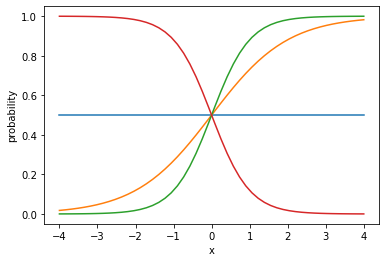

In [12]:
plt.plot(A.name,logisticRegPredict([0,0],A,['name']))
plt.plot(A.name,logisticRegPredict([0,1],A,['name']))
plt.plot(A.name,logisticRegPredict([0,2],A,['name']))
plt.plot(A.name,logisticRegPredict([0,-2],A,['name']))

plt.xlabel('x')
plt.ylabel('probability')

*Figure*. plot of logistic function for different values of slope as the intercept value is kept constant at 0.

Text(0, 0.5, 'probability')

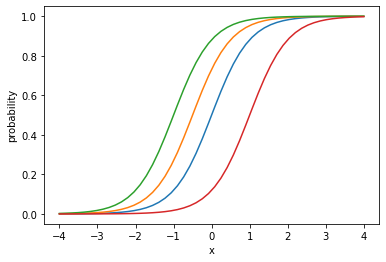

In [13]:
plt.plot(A.name,logisticRegPredict([0,2],A,['name']))
plt.plot(A.name,logisticRegPredict([1,2],A,['name']))
plt.plot(A.name,logisticRegPredict([2,2],A,['name']))
plt.plot(A.name,logisticRegPredict([-2,2],A,['name']))

plt.xlabel('x')
plt.ylabel('probability')

*Figure*. Plot of logistic function for different values of intercept as the slope value is kept constant at 2.

> As the value for the slope increases (while the intercept is kept at a constant value), the plots become steeper, meaning that they will will go from 0 to 1 (for positive slope) and 1 to 0 (for negative slope) faster. The horizontal line is showing the function for b = [0, 0]. It can be seen that it is the p = 0.5 line. Changing the slope while the intercept is kept constant, does not change the p = 0.5 crossing point.

> As the intercept value changes (while the slope is kept at a constant value), the graph is shifted. It will be shifted to the right for negative values and to the left for positive values. It can be seen that the crossing point for p = 0.5 also changes.

### Question 2 (10pt)
Make a Scatterplot of tail length (as a x-variable) against popI (Population, 1:Victoria 0:other). 
Written answer: What relationship can you see? 


Text(0, 0.5, 'Population group')

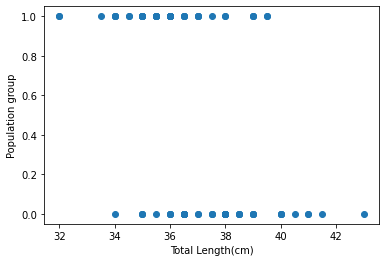

In [14]:
plt.scatter(D.tailL,D.popI)
plt.xlabel('Total Length(cm)')
plt.ylabel('Population group')

*Figure*. Scatter plot of population group vs. total length with the Victorians plotted at 1 and "other" plotted at 0.

> The larger the total length of the animal, the more likely popI is zero - that is, it is not from a Victoria population.

### Question 3 (10pt)
Write a function logisticRegLoss(b,D,y,name) that calculates the Loss function for the logistic regression (negative log-likelihood, see lecture). The function should call logisticRegPredict to get the prediction, and then calculate the Loss and the derivative of the loss in respect to all regression paramaters. The function should be able to use multiple regressors (like multRegLossRSS from previous homeworks).    

Report the negative log likelihood (and derivates) for a logistic regression model that predicts popI as a function of tailL: 
- for the parameter values [0,0]
- for the parameter values [17.5,-0.5]
- for the parameter values [25.56,-0.7]

Which one is the best parameter setting of the three? 

In [15]:
def logisticRegLoss(b,D,y,xname):
    p = logisticRegPredict(b,D,xname)
    cost = -y*np.log(p)-(1-y)*np.log(1-p)
    N=len(xname)
    grad=np.zeros(N+1)
    res = y-p
    grad[0]=-sum(res)
    for i in range(N):
        grad[i+1]=-np.sum(D[xname[i]]*res)         # Add each regressor 
    return (cost.sum(),grad)

In [16]:
logisticRegLoss([0,0],D,D.popI,['tailL'])

(72.0873067782343, array([  6. , 271.5]))

In [17]:
logisticRegLoss([17.5,-0.5],D,D.popI,['tailL'])

(63.01497836859197, array([ -14.65999642, -527.46450906]))

In [18]:
logisticRegLoss([25.56,-0.7],D,D.popI,['tailL'])

(56.72412770882329, array([ -0.37160079, -13.678462  ]))

> The third parameter setting has the best fit. 

### Question 4 (10pt)
Write a function logisticRegFit(D,y,xname,figure=True) that fits the logistic model by minimizing the above Loss function. 
- D: A data frame with the explanatory variables 
- y: A dichotomous (0 or 1) response variable 
- xname: Names of x variables to be used 
- figure: Flag (True / False) indicating if the code should produce a figure. 
When there is only one x-variable, and figure==True, then function should produce a scatter plot of the data and the predicted values. 

The function should return the log-likelihood of the data under the best model and the best fitting (maximum liklihood) estimates of b. Remember that the function value you are minimizing is the *negative* log-likelihood, and the best fitting value is stored in RES.fun

Fit a logistic regression model that predicts popI as a function of tailL. Make sure the function generates a plot. Report log-likelihood and b-values. 

In [19]:
def logisticRegFit(D,y,xname,figure=1):
    N=len(xname)
    b0=np.zeros(N+1)
    RES = so.minimize(logisticRegLoss,b0,args=(D,y,xname),jac=True)
    b = RES.x
    ll = -RES.fun # Negative function value is the log likelihood 
    p = logisticRegPredict(b,D,xname)
    if (N==1 & figure==1):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(D[xname[0]],y)
        xRange=[min(D[xname[0]]),max(D[xname[0]])]
        xp=np.arange(xRange[0],xRange[1],(xRange[1]-xRange[0])/50)
        yp=b[0]+b[1]*xp
        print(b[0])
        print(b[1])
        pp=np.exp(yp)/(1+np.exp(yp))
        ax.plot(xp,pp,'r-')
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
    return (ll,b)

25.566204374962513
-0.6996406079773353
LogLiklihood is -56.72


Text(0, 0.5, 'Probability')

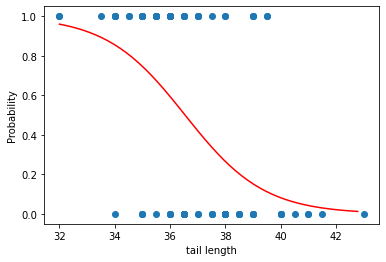

In [20]:
ll,b=logisticRegFit(D,D.popI,['tailL'])
print("LogLiklihood is {0:3.2f}".format(ll))
b
plt.xlabel('tail length')
plt.ylabel('Probability')

*Figure*. scatter plot of probability of being in a population group (1 for victorian and 0 for other) vs tail length with the logistic function showing the probability of being in each group plotted in red.

### Question 5 (10pt)
Now fit the model explaing popI from tailL and bodyL in a multiple logistic regression model. Report the log-likelihood and parameter values. Is the fit better than tailL alone? 

Also fit the model explaing popI from tailL and totalL in a multiple logistic regression model. Again, report the log-likelihood and parameter values. 

What do you observe in terms of log-likelihood and in terms of paramters? Why do these two models yield exactly the same log-liklihood? 

In [21]:
ll,b=logisticRegFit(D,D.popI,['tailL','bodyL'])
print("LogLiklihood is {0:3.2f}".format(ll))
b

LogLiklihood is -43.20


array([16.57735312, -0.98846114,  0.39180167])

In [22]:
ll,b=logisticRegFit(D,D.popI,['tailL','totalL'])
print("LogLiklihood is {0:3.2f}".format(ll))
b

LogLiklihood is -43.20


array([16.5773531 , -1.38026281,  0.39180167])

> The likelihood for both models is higher than the simple model. However, the likelihood of the two models is identical - the two models give the identical fit. This is because totalLength = bodyLength + tailLength. The same fit is achieved by subtracting 0.3918 (the weight of bodyLength) from the tailL regression weight. 